![](img/banner2.jpg)

# Energy Demand Forecasting for the Texas Power Grid

**February 11, 2022**

<br>

---

**Write-Up:** Kendall Frimodig

**Project Team:** Brock Bigalke, Katie Hickock, Joel Silverman, Kendall Frimodig

---

<br>

<p style="line-height:2">
Today I'm going to walk though a team project I recently participated in, focusing on energy demand forecasting. Texas was the subject matter, as it operates as an independent energy grid (other states of US connected) and recently experienced a near meltdown in its basic generating capacity, as a result of the winter storm of Valentines day weekend in 2021. Though the event was unprecedented, neighboring states fared the storm without the loss of life seen in Texas.
Me and my teammates thought a review of their preparedness tools might present an opportunity for positive change.<br><br>
 
<p style="line-height:2">
This blog post is a technical walkthrough of how one might replicate such an analysis, for another state or region. Therefore, lengthwise it will be somewhere in between a readme and a reading through the entire project repository of 5 jupyter notebooks. I will include code snippets but only neccesary ones, if you wish to see more comments feel free to read the notebooks on the repo link here.<br><br>

---
    
<br>
    
### Scope

<br>
    
<p style="line-height:2">
Upon investigation, we found that the only open source forecasting tool utilized by grid operators is the US energy information administration (EIA), which makes 12 hour ahead forecasts twice a day. Their model does not perform well with anomolies, and in times of crisis a more short term and reactive forecast could prove more valuable to operators. I beleive there is a need for more independant analysis focused on our electical grid, so I'll outline (in code snippets) how to access the hourly generation and demand data, and offer some tips for formatting and visualizing the data. <br><br>
    

**I will also report on our model performence versus the baseline, and how having such a model amidst a crisis could be of more utility.** <br><br>

### Relevance

<br>

<p style="line-height:2">
Before I get into some of the reasons an updated forecasting tool might better prepare Texas for another emergency, its worth highlighting that this was
on for the books. Compared to the past two artic events, this recent storm was far more severe <br>

![The 7 day average departure for the February](https://pbs.twimg.com/media/Eu2IqLqXYAMbkkb?format=jpg&name=large)<br><br>

<p style="line-height:2">
Energy must be produced in real time, to match demand - otherwise load shedding is necessary (temporary or prolonged blackouts) and as you might guess one person does not have the authority to flip the switch for select plants in such a time sensitive situation. If the demand is not sufficiently decreased in time, a generating station's circuit breaker can trip, and turning the plant back on can take days. <br><br>

<p style="line-height:2">
Once one plant goes offline, its far more likely the web of power-plants will collectively fall in a chain reaction - in the worst case the entire state could be without power for a minimum of several days. This is a tricky line to walk  since coal or natural gas power plants aren't acquiring their resources on-site, and sources outside hydroelectic and nuclear are vulnerable to their own environmental conditions to stay online.  <br><br>
    
<p style="line-height:2">
In the event of grid overload most other states can reliably pull electricity from neighboring connections, however the lone star state does not benefit form such interconnectivity. Though the figure shows two connections, data indicates little to no transfer of energy from oklahoma and mexico. In other words what little outside connection texas does have, is not comparable on scale to other interconnections. <br>

    
    
![](https://www.eia.gov/electricity/930-content/930_map.png)<br><br>

Youtuber 'Practical Engineering' explains how close the texas power crisis was to being a true catastophe and the mechanics underlying this delicate grid state in an approachable way [(link)](https://www.youtube.com/watch?v=08mwXICY4JM) <br><br>

---

### Energy Prices
    
<br>

<p style="line-height:2">
Outside of grid stability there is another upside of having accurate energy demand forecasts, cost savings for the consumer.<br><br>

<p style="line-height:2">
Accurate predictions of overall energy demand with respect to a states generation ceiling are crucial, and the rate of change (delta) of demand play a significant role in price. Although your average Texan will pay a agreed upon rate, for protection against such price gouging, many are offered access to market electricity pricing and indeed sign up. If you have 2 electric cars at home, utilizing the lower cost at night could save you alot of cash.  <br>


![average price for electricity in Texas, Feb. 2021](https://www.eia.gov/todayinenergy/images/2022.01.07/main.svg) <br><br>

<p style="line-height:2">
As you can see, the spot price per megawatt increased from the winter average of 20 dollars per megawatt to 1,485, a 7,325% increase where it remained for three days. For those opting into market rate energy, having better forecasts for demand could have saved a fortune (since the EIA forecast was far lower than played out) <br><br>

---

# Accessing the US Energy Information Agencies API

<br>

The EIA provides a variety of databases one can access. Seperate data exist for the following:

- Demand (D)
- Net generation (NG)
- Net generation by energy source (NG.***)
- Total interchange (TI)
- Day-ahead demand forecast (DF)

You can specify a single 'balancing authority' or in other words operator, a list of operators, or an entire region. 
We retreived all the above for Texas's single operator - ERCOT. 

You'll need to sign up for an API key but this is a simple process and should be approved immediatly. If generation from a particular source is '0', the query will return 'no data' and mess things up. We built in a if/else function to handle such cases. Thus our api function has three inputs: 

- Your key
- the plant(s) code
- query, each listed out above with code

Here's a summarization of our function, and code to structure the data into one dataframe

![](img/apidiagram.png)


---

## How to Pull and Analyze the Data

### imports and libraries

In [239]:
# for API section
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time

# for viz & pre-processing section
import seaborn as sns
from datetime import datetime as dt

<br><br>

### API Query Parameters

<br>

Insert your api key here from the EIA website (https://www.eia.gov/opendata/).

In [240]:
api_key= 'bge1juIp1RgbFRL6dmDi6fQYyGTDhOI0x1FAx5Yv'

<br><br>

We start with a dictionary with the keys corresponding to the (API defined) query parameters, and values to whatever we would like the columns for such values to be named. In the following custom functions, The keys will be slipped into the API URL to get the appropriate metric, and the values will then be used when creating our pandas dataframe from the request.

In [241]:
query_dict= {'D':'dmnd',
             'NG':'ngen',
             'TI':'intr',
             'DF':'pred', 
             'NG.COL':'coal', 
             'NG.WAT':'watr', 
             'NG.NG':'ngas', 
             'NG.NUC':'nucl', 
             'NG.OTH':'othr', 
             'NG.OIL':'oil', 
             'NG.SUN':'solr', 
             'NG.WND':'wind'}

query_list = list(query_dict.keys())

<br><br>

Here is a list of balancing authorities used in the API URL specifically for this project (texas has one, so for any other state, the list will be utilized). Can be amended to include more balancing authorities you are interested in. For example, you could insert a list of all possible balancing authorities to get a national dataset at the most granular level available.

In [242]:
plant_list= ['ERCO']

<br><br>

The first function will be at the core of the second, and will parse the JSON data from each plant/query code combination and return as a dataframe.

In [243]:
def extract_energy(res): 
    if res.status_code == 200:
        ts= res.json()['series'][0]['data'] # location of information from json file
        df= pd.DataFrame(ts)
    return df

<br><br>


This nested function (above function nested within) returns a dataframe based upon your api_key, plant, and specific query

In [244]:
def make_energy_df(api_key, plant, query):

    url = f'https://api.eia.gov/series/?api_key={api_key}&series_id=EBA.{plant}-ALL.{query}.HL'
    res = requests.get(url)

    if 'data' not in (res.json().keys()):
        energy_df = extract_energy(res)
        return energy_df

    else:
        return 'no data'

<br><br>

### Putting Everything Together

<br>

<p style="line-height:2">
This nested for-loop aggregates all the dataframes created using the make_energy_df function over each query in the query_list and each plant in the plant_list. It then sorts the dataframe by plant and then by datetime. In other words, one plant at a time, all available hourly data are pulled stepwise for each 'query' including specific energy type generation, demand, net generation, and interchange. An exception is made via if / else, since generation data by specific type of energy returns a 'none type' rather than 0 if the region doesn't have any production by oil, for example (and very common)<br><br>

    

**query_df** 
- the individual measure and timestamp for a specific plant (solar for example) temporary within the second nested level running through each query code
    
**energy** 
- temporary in the first nested level, overwritten after each plant's data is pulled and added to 'master_energy'. Each 'query_df' is added as a single column until each query has been completed
    
**master_energy** 
- a long form concatenated dataframe where each plant's hourly data is combined at the end
    
<br>

In [245]:
master_energy= pd.DataFrame()
for plant in plant_list:
    energy = pd.DataFrame()
    for query in query_list:
        if query == 'D':
            query_df = make_energy_df(api_key, plant, query)

            energy = energy.append(query_df, ignore_index= True)
            energy.columns = ['datetime', 'dmnd']
            energy.set_index('datetime', inplace= True)
            energy['plant']= plant

        else:
            query_df= make_energy_df(api_key, plant, query)
            if 'no data' not in query_df:

                query_df.columns= ['datetime', query_dict[query]]
                query_df.set_index('datetime', inplace= True)

                energy= pd.merge(energy, query_df[query_dict[query]], 
                                 on= 'datetime', how= 'outer')
                energy['plant']= plant

    master_energy= master_energy.append(energy)

    if len(plant_list) == 1:
        master_energy.sort_values('datetime', ascending= False, inplace= True)
    else:
        master_energy.sort_values(['plant', 'datetime'], ascending= [True, False], inplace= True)

<br><br>

---

### Check for Missingness

<br><br>

Check the length (for each plant) of the output data. In most cases, more historical data will be available for the aggregate measures, as it appears energy specific generation data is relatively newer. 

In [246]:
master_energy.groupby('plant').count()

,dmnd,ngen,intr,pred,coal,watr,ngas,nucl,othr,solr,wind
plant,,,,,,,,,,,
ERCO,60186,60168,60150,60336,34032,34032,34032,34032,34032,34032,34032


<br><br>

looking at the first 24 hours, you can see only predicted demand is available for the last 12 hours (as predictions are made twice a day. Additionally, data for combined and specific energy generation and interchange are available on a 24-hour lag.

In [247]:
lastday = master_energy[:24]
lastday.fillna(value='.')

,dmnd,plant,ngen,intr,pred,coal,watr,ngas,nucl,othr,solr,wind
datetime,,,,,,,,,,,,
20220523T00-05,.,ERCO,.,.,43998.0,.,.,.,.,.,.,.
20220522T23-05,.,ERCO,.,.,47548.0,.,.,.,.,.,.,.
20220522T22-05,.,ERCO,.,.,50570.0,.,.,.,.,.,.,.
20220522T21-05,.,ERCO,.,.,51651.0,.,.,.,.,.,.,.
20220522T20-05,.,ERCO,.,.,52118.0,.,.,.,.,.,.,.
20220522T19-05,.,ERCO,.,.,53340.0,.,.,.,.,.,.,.
20220522T18-05,51259.0,ERCO,.,.,53796.0,.,.,.,.,.,.,.
20220522T17-05,50530.0,ERCO,.,.,52913.0,.,.,.,.,.,.,.
20220522T16-05,49125.0,ERCO,.,.,51510.0,.,.,.,.,.,.,.


<br><br>

After 24 hours, all the data is available

In [248]:
master_energy[24:26]

,dmnd,plant,ngen,intr,pred,coal,watr,ngas,nucl,othr,solr,wind
datetime,,,,,,,,,,,,
20220522T00-05,48934.0,ERCO,48718.0,-215.0,44426.0,7074.0,69.0,13297.0,5051.0,65.0,0.0,23162.0
20220521T23-05,52267.0,ERCO,52354.0,87.0,48225.0,7039.0,98.0,16576.0,5050.0,57.0,0.0,23533.0


<br><br>

For proper timeseries analysis, without imputation, we'll need to ensure theres no major periods of time with unexplained missing data. 

<br>

- If you're focused specifically on eregy type, you will be limited to data from the year

- If the gaps in aggregate measures (total generation, demand) are missing for a short period of time, you can reliably impute such data

- If the gaps in such measures are much longer, you should cut off the plant's dataset from this point

<br><br>


Using the 'Missingno' package, we can easily visualize breaks in the data



In [249]:
na_check = master_energy.drop(columns={'plant'})

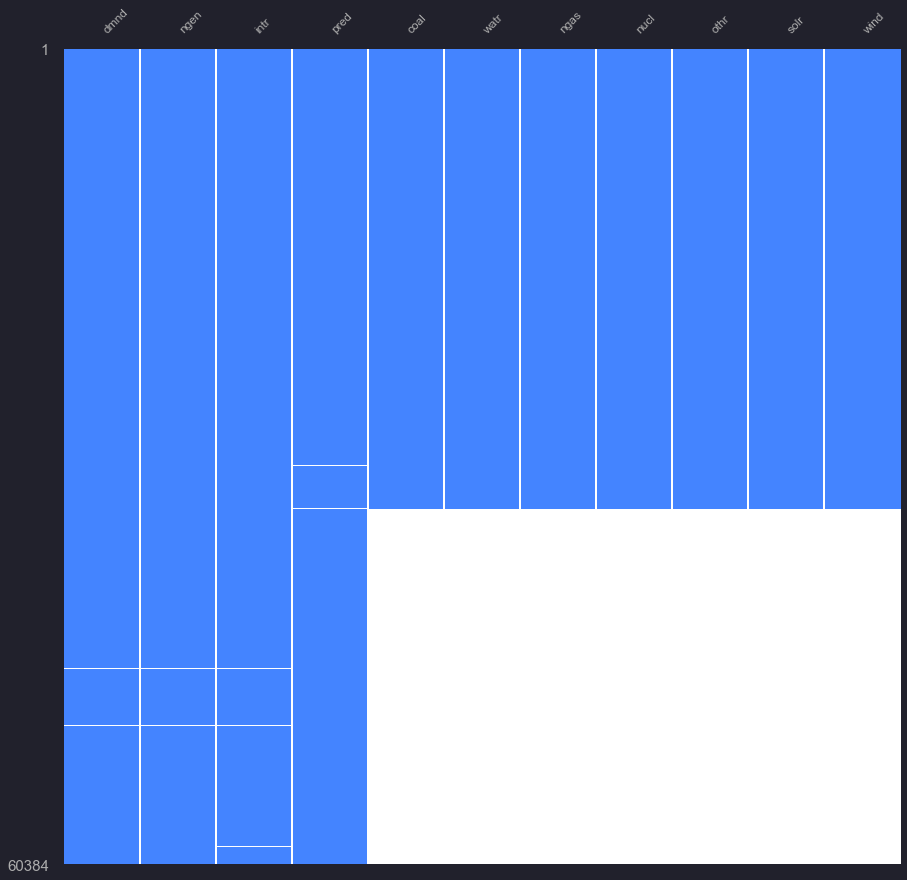

In [250]:
import missingno as msno
msno.matrix(na_check, sparkline=False, figsize=(15,15), fontsize=12, color=(0.27, 0.52, 1.0));

<br><br>

There appears to be a brief break in forecasted demand, before the time where energy type data falls off, if we want to work with just demand and forecasted demand, we can go back much further. <br>

To narrow down the specific dates, we can run through the predicted dates, and demand and produce flags when we encounter a missing value

<br> 

first we'll check the magnitude of missing hour data 

In [251]:
na_check.isnull().sum()

dmnd      198
ngen      216
intr      234
pred       48
coal    26352
watr    26352
ngas    26352
nucl    26352
othr    26352
solr    26352
wind    26352
dtype: int64

In [252]:
missing_preds = []

tmp = na_check.isnull()

for i, val in enumerate(tmp['pred']):
    if val == True:
        ymd = tmp.index[i]
        ymd = ymd[:8]
        missing_preds.append(ymd)

In [253]:
set(missing_preds)

{'20180702', '20180703', '20181112', '20181113'}

<br><br>

**For predictions, we're just missing data from two dates ( Nov 12th, July 2nd of 2018)** (with small overlap on following days)

<br>

Referencing the Missingno graph, the specific energy data falls off at this second date for missing forecast (july 2nd, 2018)

<br>

Now to check missing demand timeframes

In [254]:
missing_dmnd = []

tmp = na_check.isnull()

for i, val in enumerate(tmp['dmnd']):
    if val == True:
        ymd = tmp.index[i]
        ymd = ymd[:8]
        missing_dmnd.append(ymd)

In [255]:
set(missing_dmnd)

{'20160606',
 '20160607',
 '20160609',
 '20160610',
 '20160831',
 '20160901',
 '20170222',
 '20170223',
 '20170525',
 '20170526',
 '20170602',
 '20170603',
 '20180630',
 '20180701',
 '20181110',
 '20181111',
 '20220522',
 '20220523'}

<br><br>

There are more gaps in recorded demand, for our analysis we chose to model following any missing data, but imputing these gaps in demand and forecast could allow for utilizing more historical data

<br><br>

Saves dataframe to csv file. Can input your own title after '../data/' to make it more understandble for you. It is commented out to not unintentionally overwrite the csv file used for the analyses when this specific project occured.

In [256]:
master_energy.to_csv('data/all_erco_energy_cst.csv')

<br><br>

---

# Pre-Processing

<br>

Before you visualize or model the hourly data, you'll have to convert the timestamp to a pandas 'datetime' data type. 


Coulmn names re-formatted to 4 character codes for tidyness when assinging color palletes

In [257]:
nrg = pd.read_csv('./data/all_erco_energy_cst.csv')

nrg['datetime'] = pd.to_datetime(nrg['datetime'].str[:-3],format='%Y%m%dT%H')

<br><br>

<p style="line-height:2">
Since we're dealing with time series, we can take advantage of several time aggregation windows. As there are 11 time series models in the ARIMA, VAR, and Exponential Smoothing families to choose from, we need to visualize trends by hour, week, month, and annual windows. 

<p style="line-height:2">
The behavior of historical data determined by a variety of visuals will allow us to narrow down our choice of model, and whether additional parameters such as seasonality and holidays will be required (okhams razor: simplicity is better) 

<br><br>

**Dropping records that in the data for forcasting that don't have energy type info**

In [258]:
nrg.dropna(inplace=True)  # removes 26,000 records from before July 2018

<br><br>

**Making an hour column for plotting (0 to 23 hrs)**

In [259]:
nrg['hour_num'] = pd.to_numeric(nrg['datetime'].dt.strftime('%H'),downcast='integer')

In [260]:
# making a 'day_night' column, where 6am to 6pm is the day value; rest is night

def calc_col_vals(row):
    if row['hour_num'] < 6 or row['hour_num'] > 17:
        return 'Night'
    elif row['hour_num'] > 5 and row['hour_num'] < 18:
        return 'Day'
    else:
        return 'WTF'

In [261]:
# applying day/night values to new column 'day_night'
nrg['day_night'] = nrg.apply(lambda row: calc_col_vals(row), axis=1)

In [262]:
# checking the value counts
nrg.apply(lambda row: calc_col_vals(row), axis=1).value_counts()

Day      16990
Night    16989
dtype: int64

In [263]:
# day of the week
nrg['weekday'] = nrg['datetime'].dt.strftime('%a')

In [264]:
# numbered day of week for chart order
nrg['weekday_num'] = pd.to_numeric(nrg['datetime'].dt.strftime('%w'))

In [265]:
# an am/pm column, but not sure this is useful
#msnrg['am_pm'] = msnrg['datetime'].dt.strftime('%p')

In [266]:
nrg['month'] = nrg['datetime'].dt.strftime('%b')

In [267]:
nrg['month_num'] = nrg['datetime'].dt.strftime('%m')

In [268]:
nrg['month_num'] = pd.to_numeric(nrg['month_num'])

<br><br>

**Finally, we'll create a 'long' formatted data frame including our calculations above, where the 'wide' daframes columns are seperate dataframes for each energy source, stacked on top of eachother**



In [269]:
# Melting Energy Sources into a single column for seaborn viz

id_vars = ['datetime', 'month', 'month_num', 'weekday',
           'weekday_num', 'day_night', 'hour_num']

value_vars = ['ngen', 'coal', 'watr', 'ngas', 'nucl', 'solr', 'wind']

melt_nrg = pd.melt(nrg, id_vars, value_vars,
                   var_name='energy_type',
                   value_name='energy_mwh')

melt_nrg.set_index('datetime')

,month,month_num,weekday,weekday_num,day_night,hour_num,energy_type,energy_mwh
datetime,,,,,,,,
2022-05-22 00:00:00,May,5,Sun,0,Night,0,ngen,48718.0
2022-05-21 23:00:00,May,5,Sat,6,Night,23,ngen,52354.0
2022-05-21 22:00:00,May,5,Sat,6,Night,22,ngen,55418.0
2022-05-21 21:00:00,May,5,Sat,6,Night,21,ngen,57412.0
2022-05-21 20:00:00,May,5,Sat,6,Night,20,ngen,59173.0
...,...,...,...,...,...,...,...,...
2018-07-03 05:00:00,Jul,7,Tue,2,Night,5,wind,4550.0
2018-07-03 04:00:00,Jul,7,Tue,2,Night,4,wind,4465.0
2018-07-03 03:00:00,Jul,7,Tue,2,Night,3,wind,4671.0


<br><br>

Using column to label and columnt to color dictionaries will allow for obtaining the correct set and order if we make a temporary dataset, such as only specific types of energy.

<br>

**note** oil was not included in the dictionaries as it returned 'no-data' for our specific plant of choice. If an 'oil' column was added in yours, you must add it to the dictionary - where columns are ordered to reflect the dataframe from left to right

In [270]:
labels = {  'dmnd': 'demand',
            'ngen': 'net generation',
            'coal': 'coal',
            'watr': 'hydroelectric',
            'ngas': 'natural gas',
            'nucl': 'nuclear',
            'othr': 'other',
            'solr': 'solar',
            'wind': 'wind',
            'intr': 'total interchange',
            'pred': 'forecast demand'}


colors = {  'dmnd': '#007EB5', # baby blue
            'ngen': '#FF5555', # red
            'coal': '#ADADAD', # light grey
            'watr': '#7FFCE7', # teal
            'ngas': '#9580FF', # purple
            'nucl': '#8AFF80', # bright green
            'othr': '#F4F47B', # golden
            'solr': '#FFCA80', # orange
            'wind': '#FF80BF', # pink
            'intr': '#2A2A2A', # black
            'pred': '#FFFF55'} # bright yellow



#FFFFFF white

<br><br> 

To demonstrate this flexibility, I'll create three sets of color palletes and labels for following figures, 

- one for all measures 
- one for just energy types (leaving out oil, and hydroelectric as they are irrelevant in Texas's case)
- one for aggregate measures of demand, forecasted demand, total interchange, and net generation

In [271]:
types = ['ngen','coal','watr','ngas','nucl','solr','wind']
agg = ['dmnd','ngen','intr','pred']

all_colors = colors.values()
all_labels = labels.values()

type_colors = [colors[val] for val in types]
type_labels = [labels[val] for val in types]

agg_colors = [colors[val] for val in agg]
agg_labels = [labels[val] for val in agg]

In [272]:
type_colors

['#FF5555', '#ADADAD', '#7FFCE7', '#9580FF', '#8AFF80', '#FFCA80', '#FF80BF']

<br><br>


first to set the plot parameters **I spent a great deal of time customizing the plot aesthetic and selecting colors, feel free to use but I would appreciate an attribution!**

<br><br>

The parameters and colors were aimed to mimic my default notebook figures when I was using DataSpell IDE, with dracula pro theme

In [273]:
pltparam = {'figure.facecolor': '#21212C',
            'image.cmap': u'rocket',
            'text.color': '#ADADAD',
            'axes.labelsize': 10,
            'axes.titlesize': 20,
            'axes.axisbelow': True,
            'axes.edgecolor': '#454158',
            'axes.facecolor': '#21212C',
            'axes.grid': True,
            'axes.labelcolor': '#ADADAD',
            'axes.linewidth': 1.0,
            'font.size': 10,
            'grid.linewidth': 0.5,
            'grid.color': '#454158',
            'grid.linestyle': u'-',
            'lines.linewidth': 2,
            'lines.markeredgewidth': 0,
            'lines.markersize': 11,
            'lines.solid_capstyle': u'round',
            'patch.linewidth': 0.5,
            'legend.fontsize': 13,
            'legend.frameon': False,
            'legend.numpoints': 1,
            'legend.scatterpoints': 1,
            'xtick.labelsize': 15,
            'xtick.major.pad': 11,
            'xtick.major.width': 1.5,
            'xtick.minor.width': 0.8,
            'ytick.labelsize': 15,
            'ytick.major.pad': 11,
            'ytick.major.width': 1.5,
            'ytick.minor.width': 0.8,
            'xtick.color': '#ADADAD',
            'xtick.direction': u'out',
            'ytick.color': '#ADADAD',
            'ytick.direction': u'out',
            'font.family': [u'sans-serif'],
            'font.sans-serif': [u'Arial',
                                u'DejaVu Sans',
                                u'Liberation Sans',
                                u'Bitstream Vera Sans',
                                u'sans-serif']}

plt.rcParams.update(pltparam)



<br><br>

---

# Visualization

<br>

As mentioned previously, we'll need to understand the level of variation by year, season, and throughout the week. First, we'll look at how energy demand has increased over the years, rounding up by day from the hour format. We'll also plot the weekly average to understand how volatility changes throughout seasons, and from year to year.

In [274]:
viz = pd.read_csv('./data/all_erco_energy_cst.csv')
viz['datetime'] = pd.to_datetime(viz['datetime'].str[:-3],format='%Y%m%dT%H')

viz = viz[(viz['datetime'] > '2016-01-01 01:00:00') & (viz['datetime'] < '2022-01-01 01:00:00')]

In [275]:
viz = viz.set_index('datetime')
demand_daily = viz['dmnd'].resample('D').mean()
demand_weekly = viz['dmnd'].resample('W').mean()
demand_monthly = viz['dmnd'].resample('M').mean()


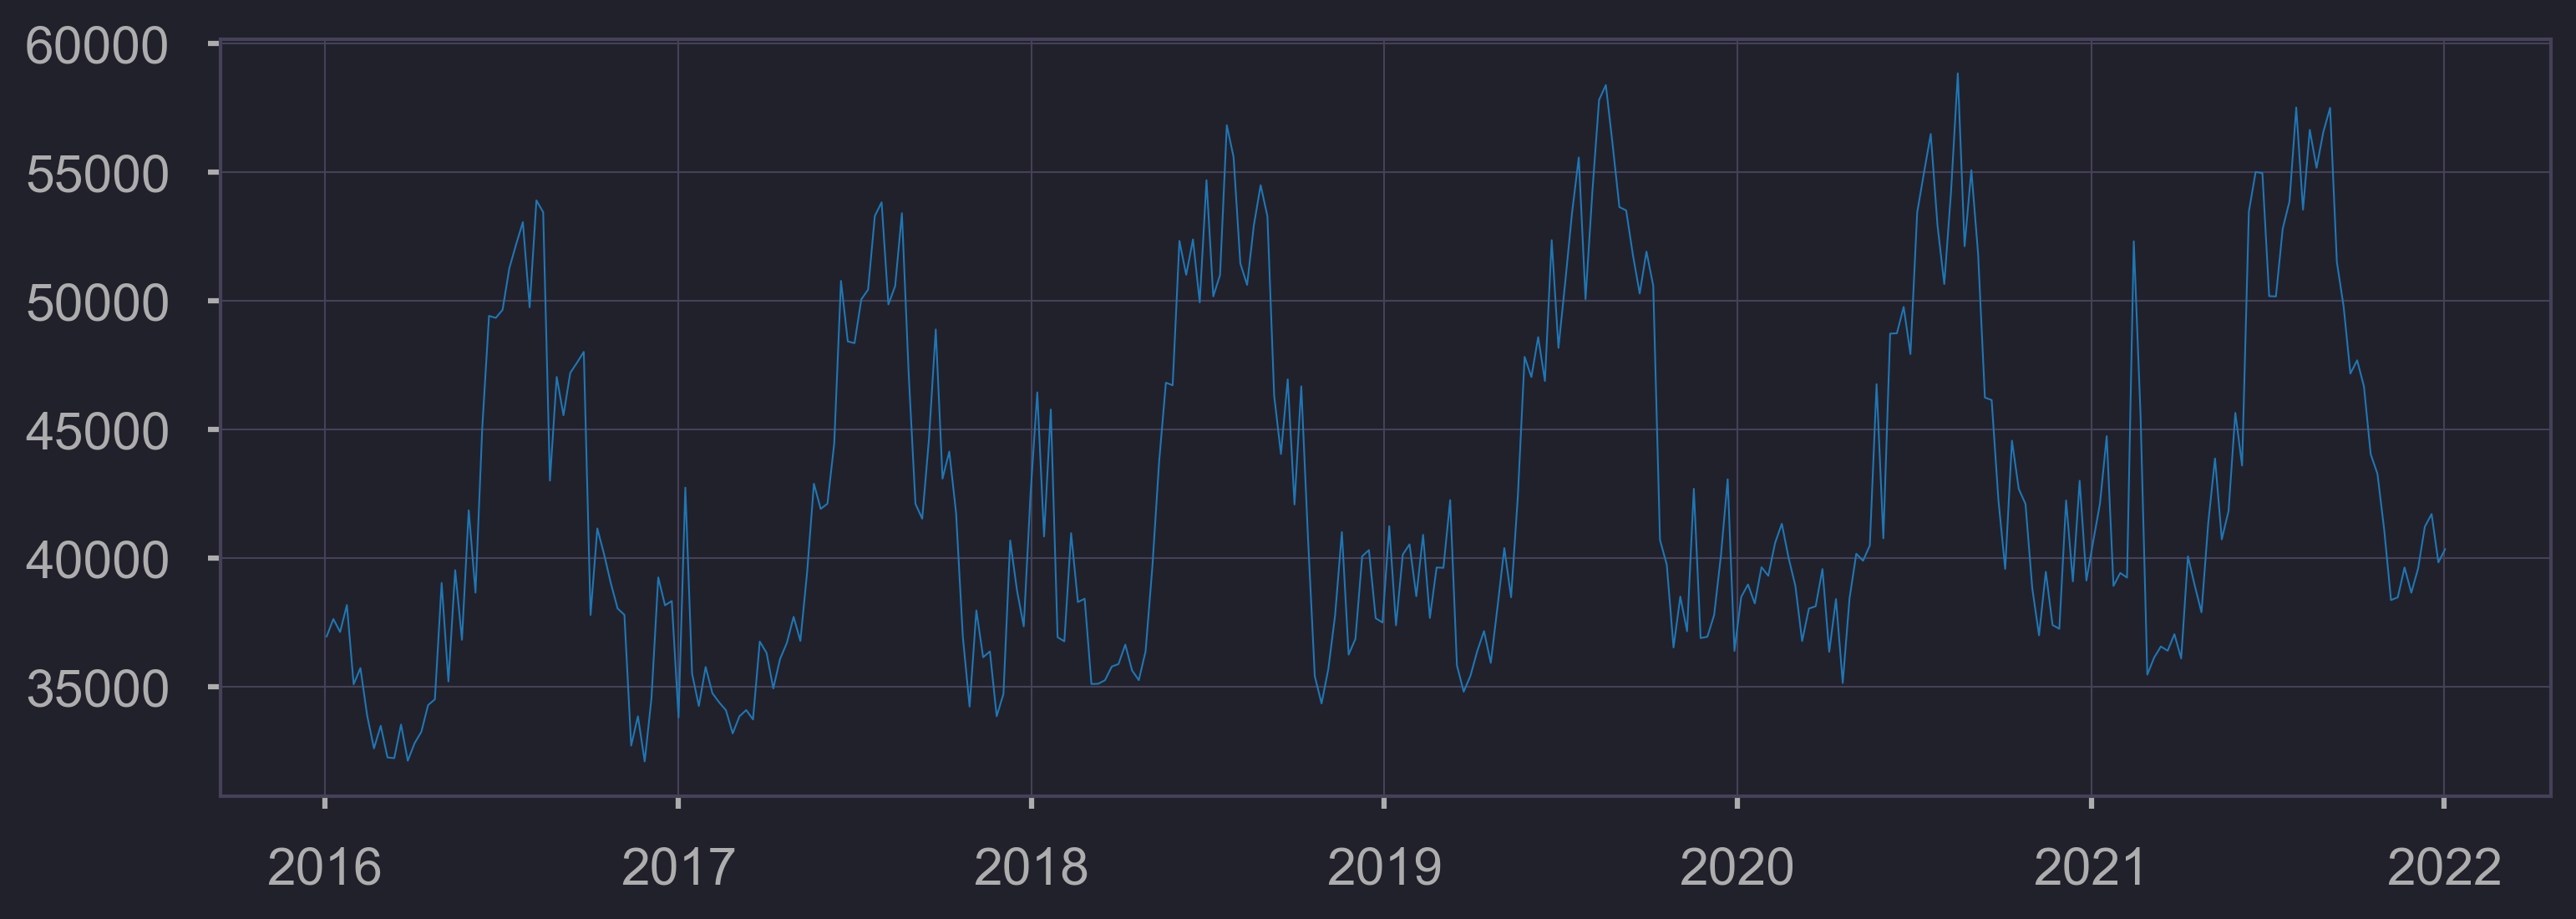

In [276]:
#demand_daily.plot(figsize = (12,6), dpi=100)
plt.figure(figsize = (12,4), dpi=300)
plt.plot(demand_weekly, linewidth=0.5);

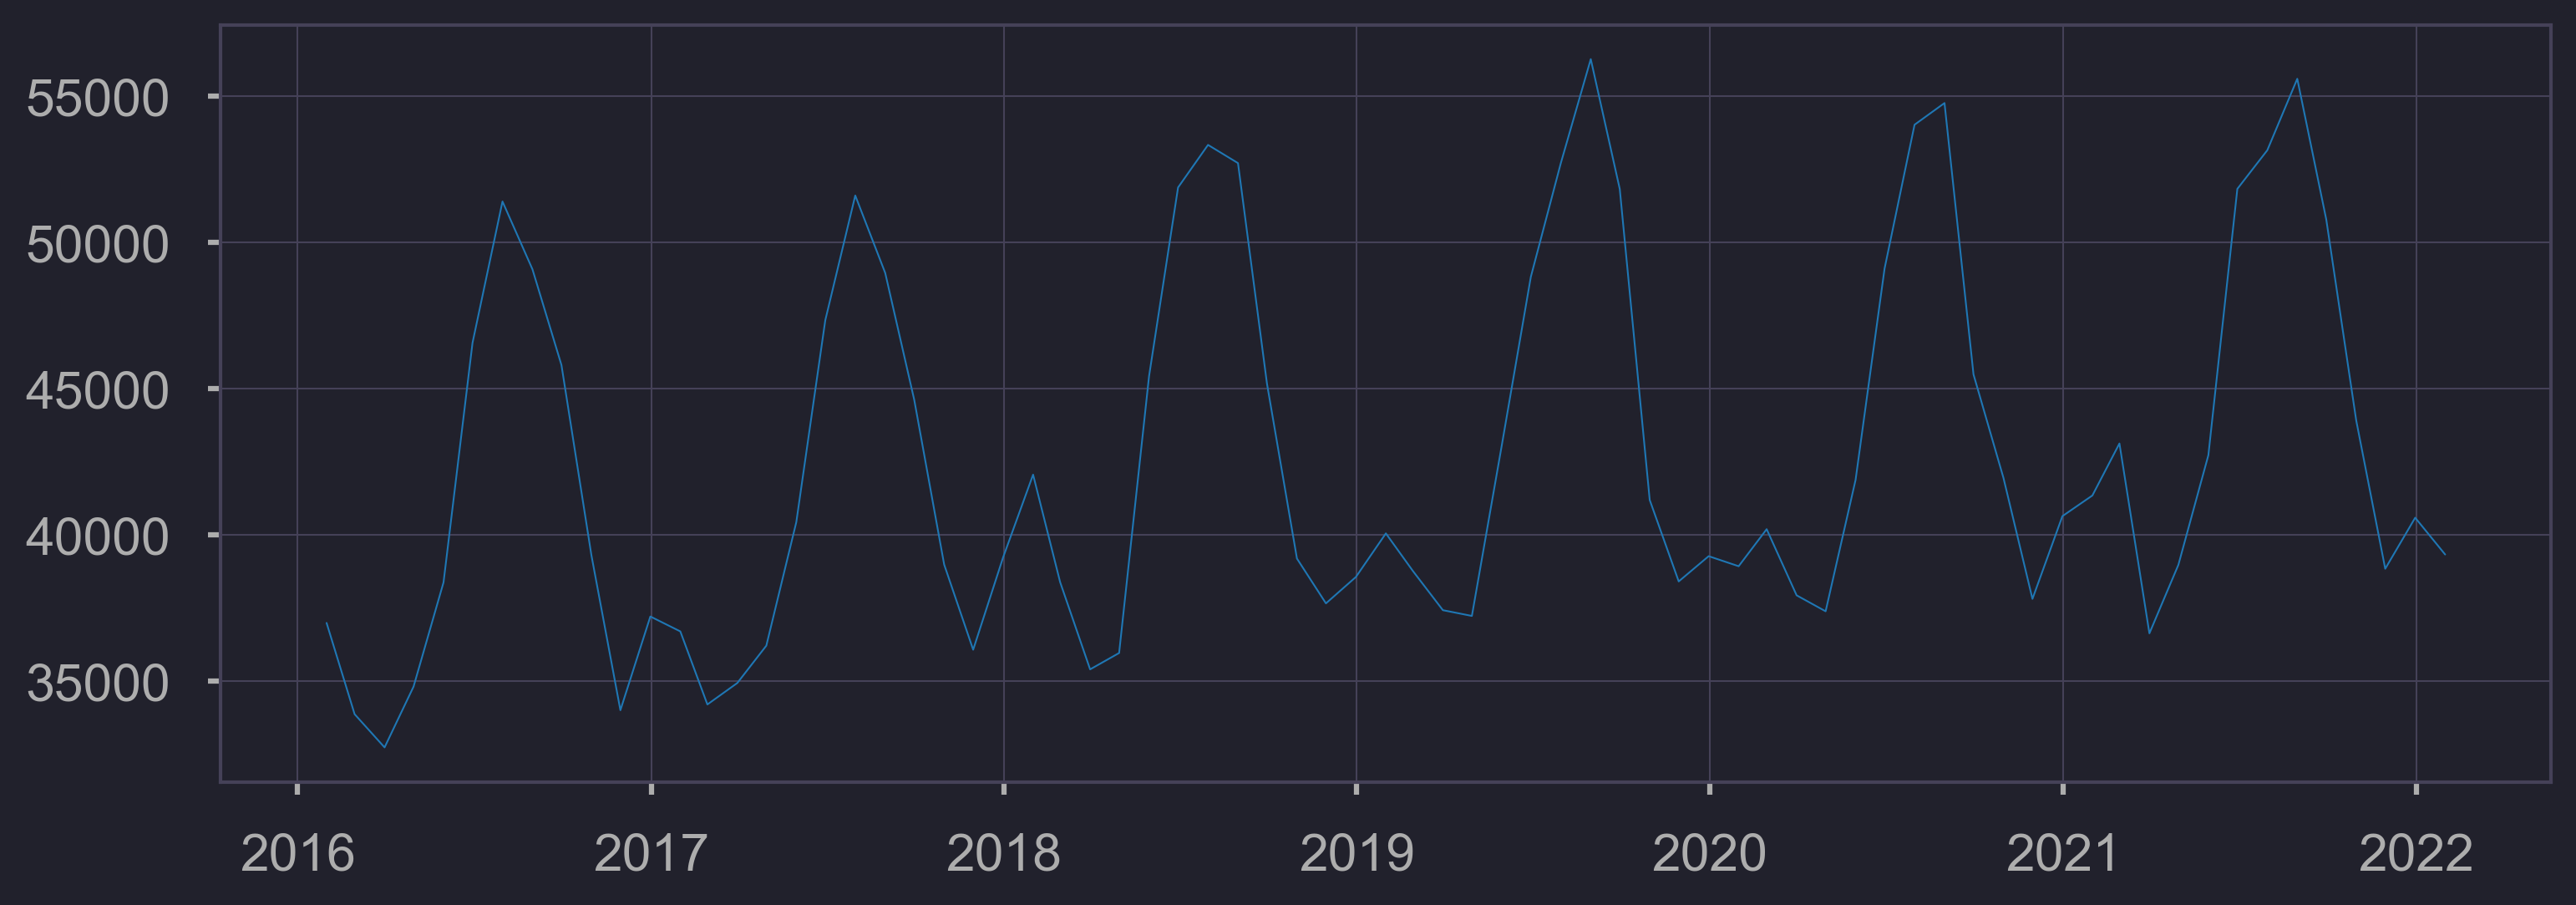

In [277]:
#demand_daily.plot(figsize = (12,6), dpi=100)
plt.figure(figsize = (12,4), dpi=300)
plt.plot(demand_monthly, linewidth=0.5);

<br><br>

Getting an idea of how energy production, **on average**, differs from month to month

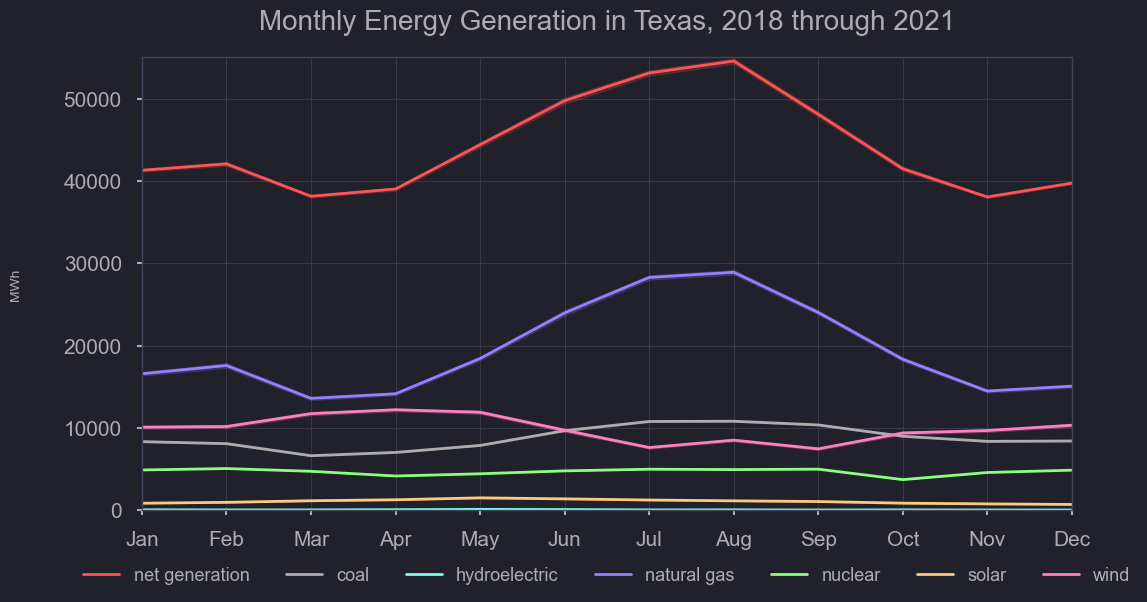

In [278]:
figtitle = "Monthly Energy Generation in Texas, 2018 through 2021"

plt.figure(figsize=(12,6), dpi=100)

sns.lineplot(x='month_num',
             y='energy_mwh',
             hue='energy_type',
             palette=type_colors,
             data=melt_nrg,
             legend='brief',
             dashes=False)

plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
            labels=['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec']) #use ticks to get months

plt.legend(bbox_to_anchor=(0.5, -0.2, 0., 0.5), loc='lower center',
           ncol=len(type_colors), labels=type_labels)

plt.ylabel("MWh", labelpad=30)
plt.ylim(0,55000)
plt.xlabel("", labelpad=30)
plt.xlim(1,12)
plt.title(figtitle, pad=20);
#plt.savefig('../output/' + figtitle + '.png', dpi=300);

<br><br>

<p style="line-height:2">
As you can see, the contribution of solar, and hydroelectric are miniscule for Texas. Some states like Washington, source over half of their generation for hydroelectric sources.Given it's geography and resources, Texas primarily relies on wind, natural gas, and coal for it's  energy. Nuclear provides a basline, though its consistency makes these other three sources primary considerations in times of additional energy demand. Knowing the primary three dynamic sources of energy for Texas, we'll investigate their fluctuations further

Text(0, 0.5, 'Mega Watt Hours')

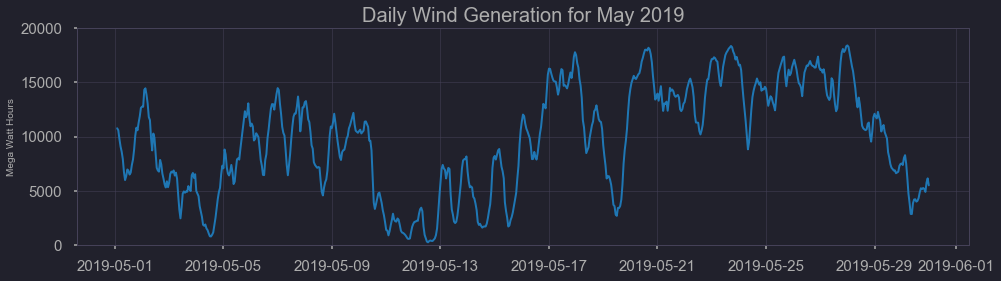

In [279]:
df = nrg[(nrg['datetime'] > '2019-05-01 01:00:00') & (nrg['datetime'] < '2019-05-31 01:00:00')].set_index('datetime')

figtitle = "Daily Wind Generation for May 2019"
plt.figure(figsize=(16,4))
sns.lineplot(x='datetime', y='wind', data= df)

plt.ylim(bottom=0, top=20000)
plt.title(figtitle)
plt.xlabel('')
plt.ylabel("Mega Watt Hours")
#plt.savefig('../output/' + figtitle + '.png', dpi=300)

<br><br>

<p style="line-height:2">
The benefit of Texas having such a large portion of it's energy come from wind, is that understanding when more supplemental energy from coal and natural gas is needed can be estimated using historical weather data. On a weekly basis, estimating the offset wind energy contributes could allow proper stocking of fossil fuel sources. Despite this, wind energy has great hour to hour, day to day variation, and presents some challenges. As you can see here, the limited use of solar energy still presents a better consistency.

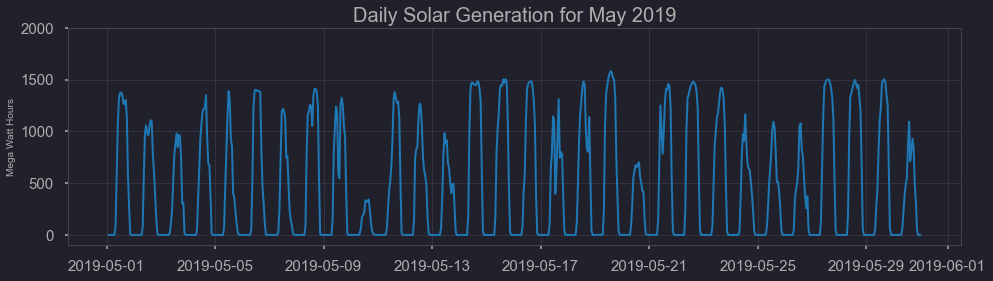

In [280]:
df = nrg[(nrg['datetime'] > '2019-05-01 01:00:00') & (nrg['datetime'] < '2019-05-31 01:00:00')].set_index('datetime')

figtitle = "Daily Solar Generation for May 2019"
plt.figure(figsize=(16,4))
sns.lineplot(x='datetime', y='solr', data= df)
plt.ylim(bottom=-100, top=2000)
plt.title(figtitle)
plt.xlabel('')
plt.ylabel("Mega Watt Hours");
#plt.savefig('../output/' + figtitle + '.png', dpi=300)

<br><br>

**Here we can see the effects of 'day of week'**

In [281]:
#plt.figure(figsize=(9,6));
figtitle = "Mean Weekly Energy Demand 2018-2021"
sns.relplot(x="weekday", y='demand',kind="line", color='#007EB5',
            data= nrg.sort_values(by='weekday_num'), height= 4, 
            aspect=3).set(title= figtitle, xlabel='', ylabel='Megawatt Hours');
#plt.savefig('../output/' + figtitle + '.png', dpi=300) 

ValueError: Could not interpret value `demand` for parameter `y`

<br><br>

**Here we can see the effects of time of day**

In [ ]:
figtitle = "Mean Daily Energy Demand"
#plt.figure(figsize=(9,6));
sns.relplot(x="hour_num", y='demand',kind="line",
                data=nrg, height=4, aspect=3).set(xlabel='',ylabel='Megawatt Hours', title=figtitle);
#plt.savefig('../output/' + figtitle + '.png', dpi=300) 

<br><br>

Here we can see the **variation** of demand at night at during the day. There is wide variation but more-so at night

In [ ]:
plt.figure(figsize=(6,6));
figtitle = "Variation in Daily Demand"
sns.violinplot(data=nrg, 
               x="day_night", y="demand", order=['Day','Night'],
               split=False, inner="quart", linewidth=1,
               palette='viridis_r').set(title=figtitle,ylabel='Megawatt Hours')  
sns.despine(left=True)
#plt.savefig('../output/' + figtitle + '.png', dpi=300) #6am to 6pm and 6pm to 6pm

<br><br>

---

# Modeling

<br>

Given the volatility and numerous temporal trends present in the data, we chose to go with a model that doesn't retain too much knowledge. This would serve a different purpose as the EIA's 12 hour ahead model, in that it would only predict an hour ahead, but be more reactive to unexpected changes. this is because the Triple exponential smoothing model makes predictions upon a short time window, and thus running the model on historical data can serve as our predictive performence


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time

In [3]:
nrg = pd.read_csv('./data/all_erco_energy_cst.csv',index_col='datetime')
# fcast = pd.read_csv('../data/erco_forecast.csv',index_col='datetime')

In [4]:
nrg.head(2)

,demand,plant,net_generation,coal,hydro,natural_gas,nuclear,other,solar,wind,total_interchange,forecast
datetime,,,,,,,,,,,,
20220206T11-06,49854.0,ERCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52270.0
20220206T10-06,53017.0,ERCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55237.0


<AxesSubplot:title={'center':'Moving Average'}, xlabel='datetime'>

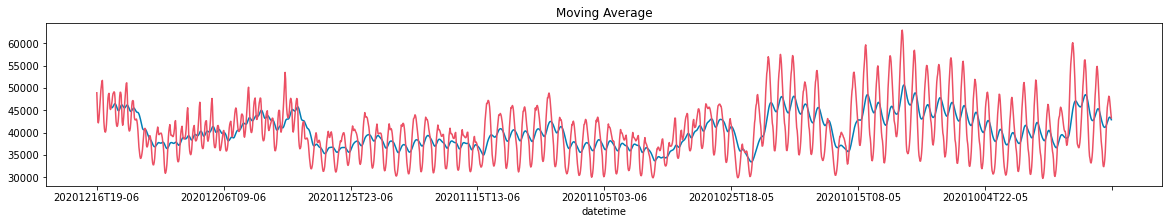

In [5]:
nrg['demand'][10000:12000].rolling(30).mean().plot(figsize=(20,3), kind='line',title='Moving Average',color='#007EB5')
nrg['demand'][10000:12000].plot(figsize=(20,3), kind='line', color='#EC5064')

Model 1 - Moving Average model: takes an average of the 30 data points(hours) to predict the next hour's demand. Does not match peaks and troughs well.

In [6]:
nrg = nrg.dropna()

In [7]:
d = nrg['demand']

In [8]:
cols = len(d) #Data Science for Supply Chain Management by Nicolas Vandepunt

d = np.append(d,[np.nan]*1)

f,a,b = np.full((3, cols+1),np.nan)

a[0] = d[0]

b[0] = d[1] -d[0]

for t in range(1,cols):
    f[t] = a[t-1] + b[t-1]
    a[t] = 0.4*d[t] + (1-0.4)*(a[t-1]+b[t-1])
    b[t] = 0.2*(a[t]-a[t-1]) + (1-0.2)*b[t-1]

for t in range(cols, cols+1):
    f[t] = a[t-1] + b[t-1]
    a[t] = f[t]
    b[t] = b[t-1]

df_three = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a, 'Trend':b,'Error':d-f})

<AxesSubplot:title={'center':'Exp Smoothing'}>

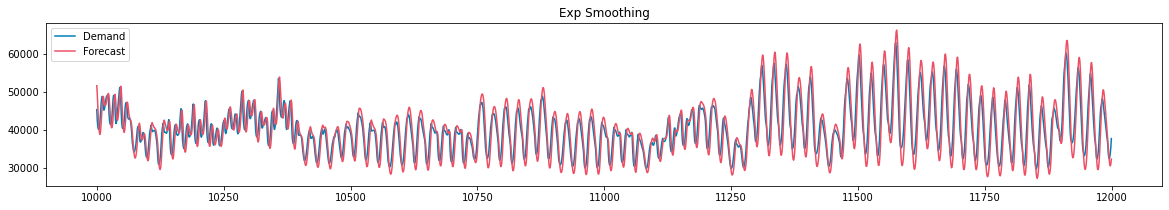

In [9]:
df_three[['Demand','Forecast']][10000:12000].plot(figsize=(20,3), kind='line',title='Exp Smoothing',color=['#007EB5','#EC5064'])

Model 2 - Simple Exponential Smoothing: Model fits better than moving average but does not account for seasonality. The bias is -0.34, MAE: 3386, and RMSE: 4189.

In [10]:
def mae_function(df):
    ###From Data Science for Supply Chain Management by Nicolas Vandepunt###
    dem_ave = df.loc[df['Error'].notnull(), 'Demand'].mean()
    bias_abs = df['Error'].mean()
    bias_rel = bias_abs / dem_ave
    print('Bias: {:0.2f}, {:.2%}'.format(bias_abs,bias_rel))
    mae_abs = df['Error'].abs().mean()
    mae_rel = mae_abs / dem_ave
    print('MAE: {:0.2f}, {:.2%}'.format(mae_abs,mae_rel))
    rmse_abs = np.sqrt((df['Error']**2).mean())
    rmse_rel = rmse_abs / dem_ave
    print('RMSE: {:0.2f}, {:.2%}'.format(rmse_abs,rmse_rel))

In [11]:
def seasonal_factors_mul(s,d,slen,cols):
    for i in range(slen):
        s[i] = np.mean(d[i:cols:slen])
    s /= np.mean(s[:slen])
    return s

In [12]:
def exp_smooth_funct(d, slen=12, extra_periods=1, alpha=0.4, beta=0.4, phi=0.9, gamma=0.3):
###Data Science for Supply Chain Management by Nicolas Vandepunt###
    cols = len(d)
    
    d = np.append(d,[np.nan]*extra_periods)
    
    f,a,b,s = np.full((4, cols+extra_periods), np.nan)
    s = seasonal_factors_mul(s,d,slen,cols)
    
    a[0] = d[0]/s[0]
    b[0] = d[1]/s[1] - d[0]/s[0]

    for t in range(1,slen):
        f[t] = (a[t-1] + phi*b[t-1])*s[t]
        a[t] = alpha*d[t]/s[t] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        
        
        
    for t in range(slen,cols):
        f[t] = (a[t-1] + phi*b[t-1]) * s[t-slen]
        a[t] = alpha * d[t]/s[t-slen] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*d[t]/a[t] + (1-gamma)*s[t-slen]
        
                
                
    for t in range(cols,cols+extra_periods):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = f[t]/s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]

    df_funct = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a, 'Trend':b,'Season':s,'Error':d-f})
    return df_funct

In [21]:
mae_function(df_three)

Bias: -0.34, -0.00%
MAE: 3385.78, 7.68%
RMSE: 4188.94, 9.50%


In [13]:
nrg_dem = nrg['demand']

In [14]:
tri_exp = exp_smooth_funct(nrg_dem, slen=12000, extra_periods=1, alpha=0.4, beta=0.4, phi=0.8, gamma=0.2)

In [15]:
tri_exp.shape

(31461, 6)

<AxesSubplot:title={'center':'Triple Exp Smoothing'}>

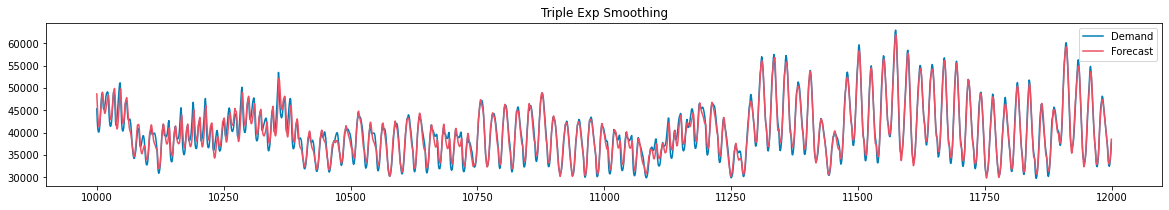

In [16]:
tri_exp[['Demand','Forecast']][10000:12000].plot(figsize=(20,3), kind='line',title='Triple Exp Smoothing',color=['#007EB5','#EC5064'])

Model 3 - Triple Exponential Smoothing: Takes exponential smoothing and introduces seasonailty parameter. The bias is -0.93, MAE: 1337, and RMSE: 1687.

In [17]:
mae_function(tri_exp)

Bias: -0.93, -0.00%
MAE: 1337.39, 3.03%
RMSE: 1687.98, 3.83%


In [18]:
tri_exp.shape

(31461, 6)

In [19]:
tri_exp.notnull().shape

(31461, 6)

In [20]:
tri_exp

,Demand,Forecast,Level,Trend,Season,Error
0,51910.0,NaN,52013.663869,-976.914964,0.998007,NaN
1,52424.0,52624.693779,51153.978701,-812.793250,1.027181,-200.693779
2,52723.0,52788.768409,50478.575483,-660.302047,1.045245,-65.768409
3,52136.0,52375.841315,49858.840107,-564.839133,1.048558,-239.841315
4,50843.0,51382.429458,49199.492629,-534.861775,1.039983,-539.429458
...,...,...,...,...,...,...
31456,41776.0,37506.125723,46603.199635,207.729000,0.852441,4269.874277
31457,43206.0,38273.522750,49180.333281,1130.563378,0.830381,4932.477250
31458,45279.0,40938.825180,52208.701486,1754.017704,0.827366,4340.174820
31459,48214.0,44750.632056,55271.581951,2067.080684,0.842234,3463.367944


<br><br>

---

# Model Interperetation

<br>

Compares EIA historical forecast, for ERCO network (texas) versus the actual demand. Those forecasts are set 24 hours in advance and the model does not re-fit every hour. Compared is our model in the second half, which re-fits each hour, starting sequentially nn

In [1]:
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from my_functions import *
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [2]:
parser = lambda x: datetime.strptime(x, '%Y%m%dT%HZ')
nrg = pd.read_csv('./data/all_erco_energy.csv', parse_dates=['datetime'], date_parser=parser)

In [3]:
# Check to see last day where data is complete (first day where null)
nrg_na = nrg[nrg['demand'].isnull()]
nrg_na.index[0]

28379

In [4]:
date_floor = '2018-11-12'
date_ceil = '2022-02-06 05'
nrg = nrg[(nrg['datetime'] > date_floor) & (nrg['datetime'] < date_ceil)].set_index('datetime')
print(nrg.shape)

(28366, 12)


In [5]:
print(nrg.index[0])
print(nrg.index[-1])

2022-02-06 04:00:00
2018-11-12 07:00:00


---

## Actual Demand Versus US EIA Forecasted Demand (Baseline Model)

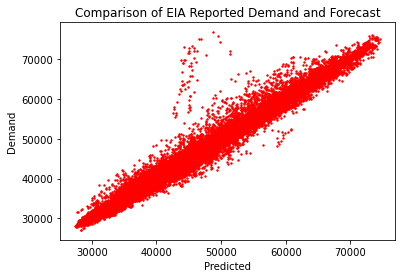

In [6]:
base_error = pd.DataFrame({'Demand': nrg['demand'],
                           'Predicted': nrg['forecast']})

plt.scatter(base_error['Demand'], base_error['Predicted'], s=2,c='red')
plt.xlabel('Predicted')
plt.ylabel('Demand')
plt.title('Comparison of EIA Reported Demand and Forecast')
plt.savefig('./output/comparing_base_demand_forecast_scatter.png')

### last Month and a Half

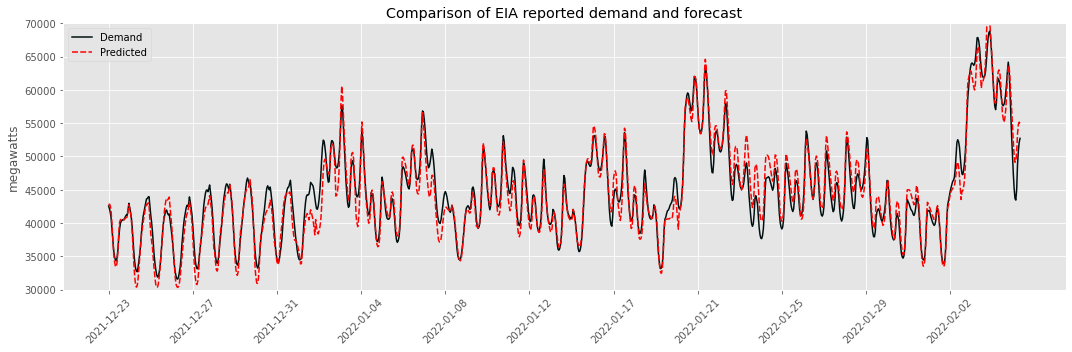

In [7]:
df = base_error
df = df[df.index > '2021-12-23']
df.sort_index(ascending=True, inplace=True)
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
sns.lineplot(data=df[['Demand','Predicted']], palette=['#001011', 'red'])
plt.ylabel('megawatts')
plt.xlabel('')
plt.ylim(bottom=30000, top=70000)
plt.xticks(ticks=df.index[::100], rotation=45)
plt.title('Comparison of EIA reported demand and forecast')
plt.tight_layout()
plt.savefig('./output/comparing_base_demand_forecast_line.png')
plt.show();

## Baseline Model Metrics

In [8]:
df = base_error
df['Error'] = df['Demand'] - df['Predicted']

In [9]:
#BASE MODEL METRICS
mae_function(df)

Bias: -173.09, -0.39%
MAE: 1107.15, 2.53%
RMSE: 1830.83, 4.18%


### Residuals

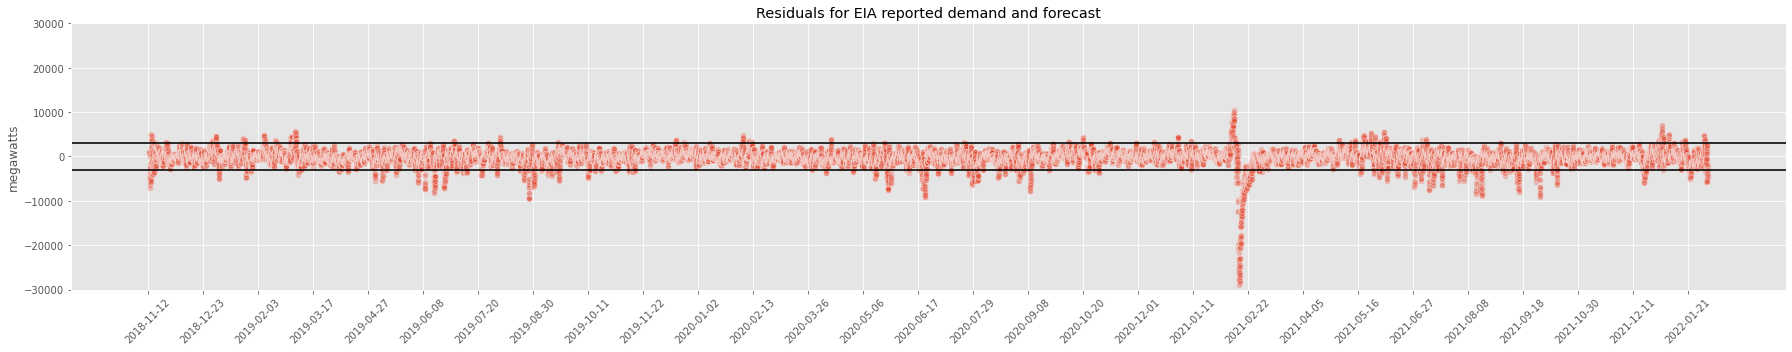

In [10]:
df.sort_index(ascending=True, inplace=True)
plt.figure(figsize=(25,5))
sns.lineplot(x=df.index,y=df['Error'], linestyle='',marker='o', alpha=0.3)
plt.ylabel('megawatts')
plt.xlabel('')
plt.ylim(bottom=-30000, top=30000)
plt.xticks(ticks=df.index[::1000], rotation=45)
plt.title('Residuals for EIA reported demand and forecast')
plt.style.use('ggplot')
plt.axhline(y = 3000, color='black', linewidth=2, alpha=.8)
plt.axhline(y = -3000, color='black', linewidth=2, alpha=.8)
plt.tight_layout()
plt.savefig('./output/basemodel_residuals.png')
plt.show();

biased towards forecast being greater than actual demand, that's preferable since excess energy can always be sent off but not generating enough can pose a major threat to the grid.

---

### Our Model

In [11]:
from datetime import datetime
parser = lambda x: datetime.strptime(x, '%Y%m%dT%HZ')

nrg = pd.read_csv('./data/all_erco_energy.csv', parse_dates=['datetime'], date_parser=parser)

In [12]:
nrg = nrg.dropna()

In [13]:
d = nrg['demand']

In [14]:
test = exp_smooth_funct(d, slen=12000, extra_periods=1, alpha=0.4, beta=0.4, phi=0.8, gamma=0.2)

In [15]:
mae_function(test)

Bias: -0.93, -0.00%
MAE: 1337.39, 3.03%
RMSE: 1687.98, 3.83%


### Rejoin date-time to model output

In [16]:
#print(nrg.head())
#print(test.head(5))
#print(nrg.tail())
#print(test.tail(5))
nrg.reset_index(inplace=True)
nrg.head(5)

,index,datetime,demand,plant,net_generation,coal,hydro,natural_gas,nuclear,other,solar,wind,total_interchange,forecast
0,11,2022-02-06 06:00:00,51910.0,ERCO,51687.0,8792.0,10.0,17825.0,5144.0,121.0,0.0,19795.0,-222.0,51511.0
1,12,2022-02-06 05:00:00,52424.0,ERCO,52179.0,9077.0,10.0,17796.0,5144.0,122.0,0.0,20030.0,-245.0,53249.0
2,13,2022-02-06 04:00:00,52723.0,ERCO,52350.0,9022.0,11.0,18119.0,5143.0,128.0,0.0,19925.0,-372.0,54965.0
3,14,2022-02-06 03:00:00,52136.0,ERCO,51572.0,8382.0,30.0,17950.0,5144.0,146.0,0.0,19921.0,-563.0,55162.0
4,15,2022-02-06 02:00:00,50843.0,ERCO,50199.0,8531.0,30.0,18028.0,5144.0,145.0,0.0,18323.0,-643.0,54814.0


In [17]:
test = test[0:31460]


In [18]:
test_error = pd.DataFrame({'Demand': test['Demand'],
                           'Predicted': test['Forecast'],
                           'Resid': test['Error'],
                           'datetime': nrg['datetime']})

In [19]:
#print(test_error.head(5))
#print(test_error.tail(5))

### Model Performance (predicted versus demand)

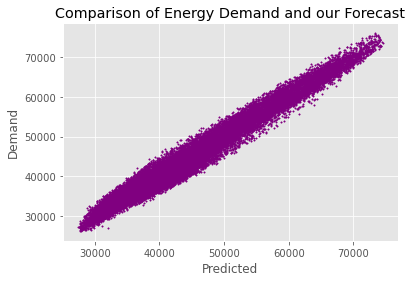

In [20]:
plt.scatter(test_error['Demand'], test_error['Predicted'], s=2, c='purple')
plt.xlabel('Predicted')
plt.ylabel('Demand')
plt.title('Comparison of Energy Demand and our Forecast')
plt.savefig('./output/comparing_test_demand_forecast_scatter.png')

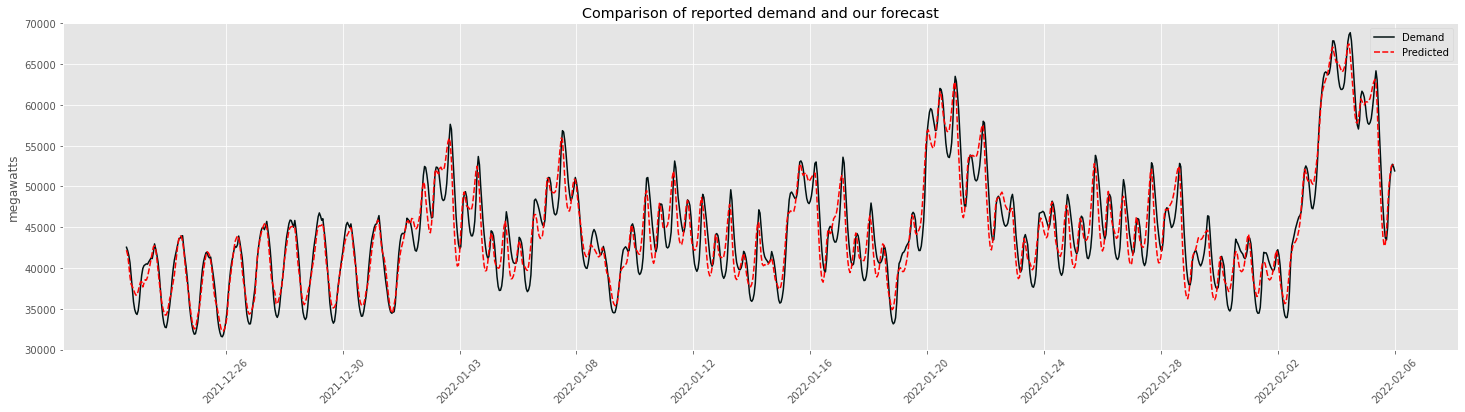

In [21]:
df = test_error[test_error['datetime'] > '2021-12-23'].set_index('datetime')
plt.figure(figsize=(25, 6))
plt.style.use('ggplot')
sns.lineplot(data=df[['Demand','Predicted']], palette=['#001011', 'red'])
plt.ylabel('megawatts')
plt.xlabel('')
plt.ylim(bottom=30000, top=70000)
plt.xticks(ticks=df.index[::100], rotation=45)
plt.title('Comparison of reported demand and our forecast')
plt.savefig('./output/comparing_ourmodel_demand_forecast1.png')
plt.show();

### Residuals

In [22]:
df= test_error

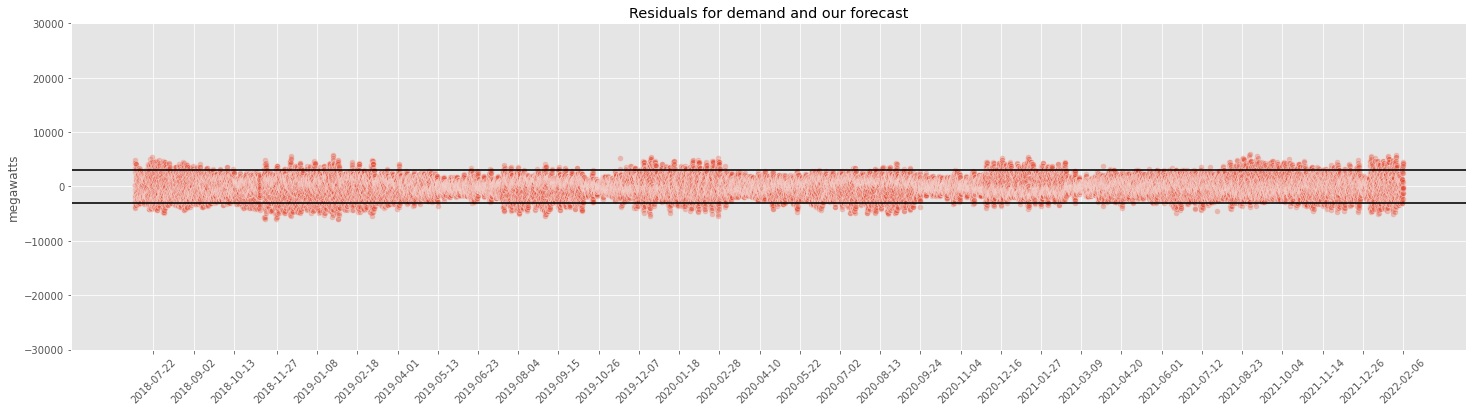

In [23]:

df= test_error.set_index('datetime')
plt.figure(figsize=(25, 6))
plt.style.use('ggplot')
sns.lineplot(x=df.index,y=df['Resid'], linestyle='',marker='o', alpha=0.3)
plt.ylabel('megawatts')
plt.xlabel('')
plt.ylim(bottom=-30000, top=30000)
plt.xticks(ticks=df.index[::1000], rotation=45)
plt.title('Residuals for demand and our forecast')
plt.axhline(y = 3000, color='black', linewidth=2, alpha=.8)
plt.axhline(y = -3000, color='black', linewidth=2, alpha=.8)
plt.savefig('./output/ourmodel_residuals.png')
plt.show();